# Normalizing flows in PyTorch (part 4)

## Advanced flows - autoregressive

Here, we expand on the idea of implementing *Normalizing Flows* [[1](#reference1),[2](#reference)] based on `torch.distributions` that we discussed in the previous tutorial. The main idea is still to *transform* a simple probability distribution through a sequence of invertible nonlinear transforms. In this second part, we will focus on more advanced types of normalizing flows recently introduced. 

In this tutorial we will cover
1. A [quick recap](#recap) of the concepts previously introduced
2. How to implement the [radial flow](#radial) from the original paper
3. An explanation on [auto-regressive flows](#ar_flow) and how to implement them
4. Using these flows for [optimization](#advanced) and their applications

**Note**: Once again, this tutorial is a work-in-progress, so I would gladly take any feedback, update or suggestions. If you have any ideas, please contact me (https://esling.github.io/)

<a id="recap"></a>
### Quick recap

#### Normalizing flows

Normalizing flow allow to transform a probability distribution, through a series of *change of variable*. If we start with a random vector $\mathbf{z}_0$ with distribution $q_0$, we can apply a series of mappings $f_i$, $i \in 1,\cdots,k$ with $k\in\mathcal{N}^{+}$ and obtain a normalizing flow. If we apply $k$ normalizing flows, the distribution of $\mathbf{z}_k\sim q_k(\mathbf{z}_k)$ in log-probability will be given by

$$
\text{log} q_K(\mathbf{z}_k) = \text{log} q_0(\mathbf{z}_0) - \sum_{i=1}^{k} \text{log} \left|\text{det}\frac{\delta f_i}{\delta\mathbf{z}_{i-1}}\right|
\tag{1} 
$$

Of course, we can perform any amount of combined transformations.

#### PyTorch distributions

We still rely on the novel [PyTorch distributions module](https://pytorch.org/docs/stable/_modules/torch/distributions/), which is defined in `torch.distributions`.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.distributions.transforms as transform
# Imports for plotting
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
matplotlib.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'
from IPython.display import HTML
# Define grids of points (for later plots)
x = np.linspace(-4, 4, 1000)
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])

#### Optimizing normalizing flows

The main interest in normalizing flows is that we could optimize the parameters of these flow in order to fit complex and rich probability distributions. In order to perform *inference*, we had to deal with the fact that the `Transform` object is not inherently parametric. To do so, we define our own `Flow` class which can be seen both as a `Transform` and also a `Module`that can be optmized

In [2]:
class Flow(transform.Transform, nn.Module):
    
    def __init__(self):
        transform.Transform.__init__(self)
        nn.Module.__init__(self)
    
    # Init all parameters
    def init_parameters(self):
        for param in self.parameters():
            param.data.uniform_(-0.01, 0.01)
            
    # Hacky hash bypass
    def __hash__(self):
        return nn.Module.__hash__(self)

Based on this minimal class, we defined a wide variety of flows in the previous tutorials, such as the *planar* and *radial* flows that are redefined here as `PlanarFlow` and `RadialFlow`

In [3]:
class PlanarFlow(Flow):

    def __init__(self, dim, h=torch.tanh, hp=(lambda x: 1 - torch.tanh(x) ** 2)):
        super(PlanarFlow, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(1, dim))
        self.scale = nn.Parameter(torch.Tensor(1, dim))
        self.bias = nn.Parameter(torch.Tensor(1))
        self.h = h
        self.hp = hp
        self.init_parameters()

    def _call(self, z):
        f_z = F.linear(z, self.weight, self.bias)
        return z + self.scale * self.h(f_z)

    def log_abs_det_jacobian(self, z):
        f_z = F.linear(z, self.weight, self.bias)
        psi = self.hp(f_z) * self.weight
        det_grad = 1 + torch.mm(psi, self.scale.t())
        return torch.log(det_grad.abs() + 1e-9)
    
class RadialFlow(Flow):

    def __init__(self, dim):
        super(RadialFlow, self).__init__()
        self.z0 = nn.Parameter(torch.Tensor(1, dim))
        self.alpha = nn.Parameter(torch.Tensor(1))
        self.beta = nn.Parameter(torch.Tensor(1))
        self.dim = dim
        self.init_parameters()

    def _call(self, z):
        r = torch.norm(z - self.z0, dim=1).unsqueeze(1)
        h = 1 / (self.alpha + r)
        return z + (self.beta * h * (z - self.z0))

    def log_abs_det_jacobian(self, z):
        r = torch.norm(z - self.z0, dim=1).unsqueeze(1)
        h = 1 / (self.alpha + r)
        hp = - 1 / (self.alpha + r) ** 2
        bh = self.beta * h
        det_grad = ((1 + bh) ** self.dim - 1) * (1 + bh + self.beta * hp * r)
        return torch.log(det_grad.abs() + 1e-9)

We discussed the fact that even though some flows might not be invertible in all regions of the space, but we are still able to access to the transformed density by explicitly performing the change of variable.

#### Invertible generative flows

Then, we discussed a very important property of the transforms that we could define as flows. Hence, if we find transformations whose Jacobian $\frac{\partial f}{\partial \mathbf{z}}$ is a *triangular matrix*, then their log-determinant is simply

$$
  \text{log }\left|\det{\frac{\partial f}{\partial \mathbf{z}}}\right| = \sum_{i=1}^D \text{log }\left|diag\left(\frac{\partial f}{\partial \mathbf{z}}\right)\right|
\tag{2} 
$$

This allowed us to consider several *element-wise* transforms that are very usual in deep learning as flows. Hence, we detailed different layers that could be implemented as normalizing flows.

### Batch Normalization

We have seen that batch normalization could be seen as a form of element-wise operation if we reparametrize it adequately (as we change the statistics of each element separately). Hence, we obtain a transform

$$
\begin{align}
\hat{\mathbf{x}_b} &= \frac{\mathbf{x}_b-\tilde{\mu_b}}{\sqrt{\tilde{\sigma_b}^2 + \epsilon}}\\
f\left(\mathbf{x}\right) &=\gamma\hat{\mathbf{x}_b}+\beta
\end{align}
\tag{3} 
$$

where $\mathbf{x}_b$ is one batch of data, $\tilde{\mu_b}=\mathbb{E}\left[\mathbf{x}_b\right]$ and $\tilde{\sigma_b}^2=Var\left[\mathbf{x}_b\right]$ are this batch mean and variance, and $\gamma$ and $\beta$ are two trainable parameters representing shift and scale. Hence, as we see this as an element-wise operation, we can obtain the overall log determinant of the jacobian as

$$
\text{log }\left|\det{\frac{\partial f}{\partial \mathbf{x}}}\right| = \sum_{i=1}^D \left[ \text{log }\left(\gamma_i\right) - \frac{1}{2}\text{log }\left(\tilde{\sigma_i}^2 + \epsilon\right) \right]
\tag{4} 
$$

This leads to define the `BatchNormFlow` as follows

In [4]:
class BatchNormFlow(Flow):

    def __init__(self, dim, momentum=0.95, eps=1e-5):
        super(BatchNormFlow, self).__init__()
        # Running batch statistics
        self.r_mean = torch.zeros(dim)
        self.r_var = torch.ones(dim)
        # Momentum
        self.momentum = momentum
        self.eps = eps
        # Trainable scale and shift (cf. original paper)
        self.gamma = nn.Parameter(torch.ones(dim))
        self.beta = nn.Parameter(torch.zeros(dim))
        
    def _call(self, z):
        if self.training:
            # Current batch stats
            self.b_mean = z.mean(0)
            self.b_var = (z - self.b_mean).pow(2).mean(0) + self.eps
            # Running mean and var
            self.r_mean = self.momentum * self.r_mean + ((1 - self.momentum) * self.b_mean)
            self.r_var = self.momentum * self.r_var + ((1 - self.momentum) * self.b_var)
            mean = self.b_mean
            var = self.b_var
        else:
            mean = self.r_mean
            var = self.r_var
        x_hat = (z - mean) / var.sqrt()
        y = self.gamma * x_hat + self.beta
        return y

    def _inverse(self, x):
        if self.training:
            mean = self.b_mean
            var = self.b_var
        else:
            mean = self.r_mean
            var = self.r_var
        x_hat = (z - self.beta) / self.gamma
        y = x_hat * var.sqrt() + mean
        return y
        
    def log_abs_det_jacobian(self, z):
        # Here we only need the variance
        mean = z.mean(0)
        var = (z - mean).pow(2).mean(0) + self.eps
        log_det = torch.log(self.gamma) - 0.5 * torch.log(var + self.eps)
        return torch.sum(log_det, -1)

### Target densities and optimization

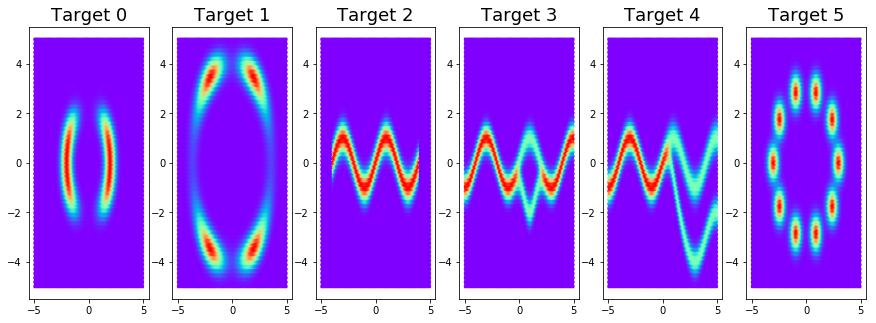

In [5]:
import math

w1 = lambda z: torch.sin(2 * math.pi * z[:, 0] / 4)
w2 = lambda z: 3 * torch.exp(-0.5 * ((z[:, 0] - 1) / 0.6) ** 2)
w3 = lambda z: 3 * (1.0 / (1 + torch.exp(-(z[:, 0] - 1) / 0.3)))

def density_mvn(z, mu=torch.FloatTensor([[0, 0]]), sig=torch.FloatTensor([[1, 1]])):
    z = z[:, None, :] - mu[None, :, :]
    sig_inv = 1./sig
    exponent = -0.5 * torch.sum(z * sig_inv[None, :, :] * z, (1, 2))
    return torch.exp(exponent)

def density_bivar(z):
    add1 = 0.5 * ((torch.norm(z, 2, 1) - 2) / 0.4) ** 2
    add2 = -torch.log(torch.exp(-0.5 * ((z[:, 0] - 2) / 0.6) ** 2) + torch.exp(-0.5 * ((z[:, 0] + 2) / 0.6) ** 2))
    return torch.exp(-(add1 + add2))

def density_ring(z):
    z1, z2 = torch.chunk(z, chunks=2, dim=1)
    norm = torch.sqrt(z1 ** 2 + z2 ** 2)
    exp1 = torch.exp(-0.5 * ((z1 - 2) / 0.8) ** 2)
    exp2 = torch.exp(-0.5 * ((z1 + 2) / 0.8) ** 2)
    u = 0.5 * ((norm - 4) / 0.4) ** 2 - torch.log(exp1 + exp2)
    return torch.exp(-u)

def density_wave(z):
    z = torch.reshape(z, [z.shape[0], 2])
    z1, z2 = z[:, 0], z[:, 1]
    u = 0.5 * ((z2 - w1(z))/0.4) ** 2
    u[torch.abs(z1) > 4] = 1e8
    return torch.exp(-u)

def density_wave_twist(z):
    in1 = torch.exp(-0.5 * ((z[:, 1] - w1(z)) / 0.35) ** 2)
    in2 = torch.exp(-0.5 * ((z[:, 1] - w1(z) + w2(z)) / 0.35) ** 2)
    return torch.exp(torch.log(in1 + in2 + 1e-9))

def density_wave_split(z):
    in1 = torch.exp(-0.5 * ((z[:, 1] - w1(z)) / 0.4) ** 2)
    in2 = torch.exp(-0.5 * ((z[:, 1] - w1(z) + w3(z)) / 0.35) ** 2)
    return torch.exp(torch.log(in1 + in2))
    
def density_circle(z, n_dens=10):
    full_dens = []
    for n in range(n_dens):
        x = math.cos((n / float(n_dens)) * 2 * math.pi) * 3
        y = math.sin((n / float(n_dens)) * 2 * math.pi) * 3
        full_dens.append(density_mvn(z, mu=torch.FloatTensor([[x, y]]), sig= 0.1 * torch.FloatTensor([[1, 2]])).unsqueeze(1))
    return torch.sum(torch.cat(full_dens, dim=1), dim=1)

x = np.linspace(-5, 5, 1000)
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])
# Set of target densities
targets = [density_bivar, density_ring, density_wave, density_wave_twist, density_wave_split, density_circle]
# Plot these lads
plt.figure(figsize=(15, 5))
for t in range(len(targets)):
    plt.subplot(1, len(targets), t+1)
    plt.hexbin(z[:,0], z[:,1], C = targets[t](torch.Tensor(z)).numpy().squeeze(), cmap='rainbow')
    plt.title('Target ' + str(t), fontsize=18);

In [6]:
# Main class for normalizing flow
class NormalizingFlow(nn.Module):

    def __init__(self, dim, blocks, flow_length, density):
        super().__init__()
        biject = []
        for f in range(flow_length):
            for b_flow in blocks:
                biject.append(b_flow(dim))
        self.transforms = transform.ComposeTransform(biject)
        self.bijectors = nn.ModuleList(biject)
        self.base_density = density
        self.final_density = distrib.TransformedDistribution(density, self.transforms)
        self.log_det = []

    def forward(self, z):
        self.log_det = []
        # Applies series of flows
        for b in range(len(self.bijectors)):
            self.log_det.append(self.bijectors[b].log_abs_det_jacobian(z))
            z = self.bijectors[b](z)
        return z, self.log_det
    
import torch.optim as optim
# Define our loss
def loss(density, zk, log_jacobians):
    sum_of_log_jacobians = sum(log_jacobians)
    return (-sum_of_log_jacobians - torch.log(density(zk) + 1e-9)).mean()

In [7]:
def train_flow(flow, loss, optimizer, scheduler, target_density, epochs=10001, plot_it=1000):
    ref_distrib = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))
    ims = []
    #fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 7))
    fig = plt.figure(figsize=(10, 10))
    # Main optimization loop
    for it in range(epochs):
        # Draw a sample batch from Normal
        samples = ref_distrib.sample((512, ))
        # Evaluate flow of transforms
        zk, log_jacobians = flow(samples)
        # Evaluate loss and backprop
        #optimizer.zero_grad()
        loss_v = loss(target_density, zk, log_jacobians)
        loss_v.backward()
        optimizer.step()
        scheduler.step()
        if (it % plot_it == 0):
            print('Loss (it. %i) : %f'%(it, loss_v.item()))
            # Draw random samples
            samples = ref_distrib.sample((int(1e5), ))
            # Evaluate flow and plot
            zk, _ = flow(samples)
            zk = zk.detach().numpy()
            im = plt.hexbin(zk[:,0], zk[:,1], cmap='rainbow', animated='True')
            ims.append([im])
    #ax1.hexbin(z[:,0], z[:,1], C=target_density(torch.Tensor(z)).numpy().squeeze(), cmap='rainbow')
    #ax1.set_title('Target density', fontsize=15);
    #ax2.hexbin(zk[:,0], zk[:,1], cmap='rainbow')
    #ax2.set_title('Final approximation', fontsize=15)
    anim = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
    HTML(anim.to_html5_video())
    anim.save("check.mp4")
    #ax3.set_title('Optimization process', fontsize=15)

<a id="ar_flow"></a>
# Auto-regressive flows

Recently several models have been proposed to perform *autoregressive density estimation*. This problem is particularily relevant for time series (such as raw audio), but has been shown to provide excellent results for images as well (PixelCNN, DRAW). The goal is to learn the joint densities $p(\mathbf{x}_{1:N})$ by decomposing it into a product of conditional densities

$$
p(\mathbf{x})=\prod_{i}p(\mathbf{x}_i\vert\mathbf{x}_{1:i-1})
\tag{5} 
$$

Hence, each point $\mathbf{x}_i$ depends on the previous $i-1$ values. At first glance, this could look problematic for using this in the framework of flows. We have seen that we needed to find transformations whose Jacobian $\frac{\partial f}{\partial \mathbf{z}}$ is a *triangular matrix*, then their log-determinant is simply

$$
  \text{log }\left|\det{\frac{\partial f}{\partial \mathbf{z}}}\right| = \sum_{i=1}^D \text{log }\left|diag\left(\frac{\partial f}{\partial \mathbf{z}}\right)\right|
\tag{6} 
$$

Regarding autoregressive transforms, if dimension $i$ of the transformed variable only depends on the previous $i-1$ dimensions of the input variable, it is shown in [1] that the Jacobian of this transformation will be triangular. As the determinant of a triangular matrix is equal to the product of terms on its diagonal, then if $\mathcal{J^f}=\frac{\partial f}{\partial \mathbf{z}} \in \mathcal{R}^{D \times D}$ is the Jacobian of the transform $f$ with $\mathbf{z}'_i = f(\mathbf{z}_{1:i-1})$, then

$$
  \text{log }\left|\det{J^f}\right| = \sum_{i=1}^D \text{log }\left|J_{ii}\right|
\tag{7} 
$$

This property first put forward by Dinh et al. [2] (detailed in the following section) in their proposed Real-NVP is extremely handy, as we can reduce the computation of the Jacobian to a simple sum. At the core of all the following flows (Real-NVPs, MAF and IAF), is the goal to perform a type of *scale and shift* transform. Hence, we will try to keep an homogeneous notation by always noting $\mathbf{z}'_i = f(\mathbf{z}_{1:i-1})$ as the flow and refer to $g_{\mu}(\cdot)$ and $g_{\sigma}(\cdot)$ as two trainable functions (usually defined as neural networks) that aim to learn shift and scale respectively.

## Real Non-Volume Preserving flows (Real-NVPs)

At the core of the Real-NVP [2] model is the definition of bijectors called *affine coupling layers*. Hence, given an input $\mathbf{z}\in\mathbb{R}^D$, an integer $k$, with $1 < k < D$ and $g_{\mu}:\mathcal{R}^k \mapsto \mathcal{R}^{D-k}$ and $g_{\sigma}:\mathcal{R}^k \mapsto \mathcal{R}^{D-k}$, Real-NVP flows are defined as

$$
  \mathbf{z}'_{1:k} = \mathbf{z}_{1:k},\\
  \mathbf{z}'_{k+1:D} = \mathbf{z}_{k+1:D} \odot exp(g_{\sigma}(\mathbf{z}_{1:k})) + g_{\mu}(\mathbf{z}_{1:k})
\tag{8} 
$$

where $\odot$ defines the element-wise multiplication operator. As we can see, this transform copies the $k$ first dimensions and applies a *scale and shift* operation to the remaining $d - k$ dimensions. Therefore, this defines an autoregressive transform, and the Jacobian is defined as an identity matrix $\mathbf{I}_k$ for the $k$ first dimensions. The second part is lower triangular and only contains $exp(g_{\sigma}(\mathbf{z}_{1:k}))$ on its diagonal. Therefore, the log-determinant of the Jacobian is simply

$$
  \text{log }\left|\frac{\partial f(\mathbf{z})}{\partial \mathbf{z}}\right| = \sum_{i=k+1}^{D} \left|g_{\sigma}(\mathbf{z}_{1:k})\right|
\tag{9} 
$$

This type of flow is very interesting, as it can be simply implemented and both the sampling and inference can be efficiently performed, as all operations of a flow can be performed in parallel. Furthermore, as detailed in [2], the inverse transform of this flow is also rather simple

$$
\mathbf{z}_{1:k} = \mathbf{z}'_{1:k},\\
\mathbf{z}_{k+1:D} = \frac{\mathbf{z}'_{k+1:D} - g_{\mu}(\mathbf{z}'_{1:k})}{g_\sigma(\mathbf{z}_{1:k})}
\tag{10} 
$$

As we explained before, $g_{\mu}$ and $g_{\sigma}$ will be implemented as neural networks, which are usually not invertible. However, we see here that we do not need to invert these but we are still able to have a transform which is globally invertible.

Following our previous formalism, we can easily produce a naive (we will see later why) implementation of this `AffineCouplingFlow`.


In [14]:
# Affine coupling flow
class AffineCouplingFlow(Flow):
    def __init__(self, dim, n_hidden=64, n_layers=3, activation=nn.ReLU):
        super(AffineCouplingFlow, self).__init__()
        self.k = dim // 2
        self.g_mu = self.transform_net(self.k, dim - self.k, n_hidden, n_layers, activation)
        self.g_sig = self.transform_net(self.k, dim - self.k, n_hidden, n_layers, activation)
        self.init_parameters()
        self.bijective = True

    def transform_net(self, nin, nout, nhidden, nlayer, activation):
        net = nn.ModuleList()
        for l in range(nlayer):
            net.append(nn.Linear(l==0 and nin or nhidden, l==nlayer-1 and nout or nhidden))
            net.append(activation())
        return nn.Sequential(*net)
        
    def _call(self, z):
        z_k, z_D = z[:, :self.k], z[:, self.k:]
        zp_D = z_D * torch.exp(self.g_sig(z_k)) + self.g_mu(z_k)
        return torch.cat((z_k, zp_D), dim = 1)

    def _inverse(self, z):
        zp_k, zp_D = z[:, :self.k], z[:, self.k:]
        z_D = (zp_D - self.g_mu(zp_k)) / self.g_sig(zp_k)
        return torch.cat((zp_k, z_D))

    def log_abs_det_jacobian(self, z):
        z_k = z[:, :self.k]
        return -torch.sum(torch.abs(self.g_sig(z_k)))

Now, even if we would like to quickly test our newest flow as before, this one includes two MLPs to compute its parameters. Therefore, it is slightly harder to test it explicitly, but you can be confident that this flow performs a scaling and shifting of part of the input dimensions

### Dimension ordering (important note)
The astute reader might have noticed that the previous flow always simply copies the first $k$ dimensions and only act on the remaining $D-k$ dimensions. Therefore, if we simply apply a sequence of these flows, these $k$ dimensions will remain unafected by the flow. To avoid this situation, authors propose to reverse the ordering of dimensions after every step. Hence, the dimensions that are simply copied in one step will be transformed in the next one. This can be very easily implemented in the `ReverseFlow` class (note here that the `log_abs_det_jacobian` function simply returns a vector of zeros, as there is no real change of variable involved)

In [9]:
class ReverseFlow(Flow):

    def __init__(self, dim):
        super(ReverseFlow, self).__init__()
        self.permute = torch.arange(dim-1, -1, -1)
        self.inverse = torch.argsort(self.permute)
        
    def _call(self, z):
        return z[:, self.permute]

    def _inverse(self, z):
        return z[:, self.inverse]
    
    def log_abs_det_jacobian(self, z):
        return torch.zeros(z.shape[0], 1)

Another possibility is also to perform a random permutation of the dimensions ordering, which is defined here as the `ShuffleFlow` class (note that here we can simply base this class on the `ReverseFlow` implementation, as this is just a different ordering of dimensions)

In [10]:
class ShuffleFlow(ReverseFlow):

    def __init__(self, dim):
        super(ShuffleFlow, self).__init__(dim)
        self.permute = torch.randperm(dim)
        self.inverse = torch.argsort(self.permute)

### Masked R-NVP and convolutions

As we said earlier, our first implementation is slightly naive, as it involves to split our input in parts. This can be efficiently replaced by relying on a masking operation. Indeed, as proposed by [2], the original coupling layer can be replaced by defining a binary mask $\mathbf{b}$, which turns the original equation in

$$
\mathbf{z}' = (\mathbf{b} \odot \mathbf{z}) + (1 - \mathbf{b}) \odot \left(\mathbf{z} \odot exp(g_{\sigma}(\mathbf{b} \odot \mathbf{z})) + g_{\mu}(\mathbf{b} \odot \mathbf{z}) \right)
\tag{11} 
$$

This provides both the advantage of simplicity, but also that we can now define any masking pattern for deciding which dimensions are copied or transformed in the flow. Notably in the case of convolutions, the authors show [2] that it can allow to define either *checkerboard* or *channel-wise* masking. Also, we will see later that this idea of *masked computation* is central to other types of autoregressive flows. Here, we implement this idea as a `MaskedCouplingFlow` class

In [11]:
# Affine coupling flow
class MaskedCouplingFlow(Flow):
    def __init__(self, dim, mask=None, n_hidden=64, n_layers=2, activation=nn.ReLU):
        super(MaskedCouplingFlow, self).__init__()
        self.k = dim // 2
        self.g_mu = self.transform_net(dim, dim, n_hidden, n_layers, activation)
        self.g_sig = self.transform_net(dim, dim, n_hidden, n_layers, activation)
        self.mask = mask or torch.cat((torch.ones(self.k), torch.zeros(self.k))).detach()
        self.init_parameters()
        self.bijective = True

    def transform_net(self, nin, nout, nhidden, nlayer, activation):
        net = nn.ModuleList()
        for l in range(nlayer):
            module = nn.Linear(l==0 and nin or nhidden, l==nlayer-1 and nout or nhidden)
            module.weight.data.uniform_(-0.1, 0.1)
            net.append(module)
            net.append(activation())
        return nn.Sequential(*net)
        
    def _call(self, z):
        z_k = (self.mask * z)
        zp_D = z * torch.exp(self.g_sig(z_k)) + self.g_mu(z_k)
        return z_k + (1 - self.mask) * zp_D

    def _inverse(self, z):
        zp_k = (self.mask * z)
        z_D = (((1 - self.mask) * z) - self.g_mu(zp_k)) / self.g_sig(zp_k)
        return zp_k + z_D

    def log_abs_det_jacobian(self, z):
        return -torch.sum(torch.abs(self.g_sig(z * self.mask)))

### Testing it all together

In [ ]:
# Our different flow blocks
block_real_nvp = [ AffineCouplingFlow, ReverseFlow, BatchNormFlow ]
# Create normalizing flow
flow_real_nvp = NormalizingFlow(dim=2, blocks=block_real_nvp, flow_length=32, density=distrib.MultivariateNormal(torch.zeros(2), torch.eye(2)))
# Create optimizer algorithm
optimizer = optim.Adam(flow_real_nvp.parameters(), lr=1e-3)
# Add learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.99995)
# Launch the optimization
train_flow(flow_real_nvp, loss, optimizer, scheduler, density_wave, epochs=1000, plot_it=20)

Loss (it. 0) : 36.847980
Loss (it. 20) : 4.121504
Loss (it. 40) : 2.127138
Loss (it. 60) : 3.278731


## Introducing dimension dependencies

In order to extend our *affine coupling flow*, we can introduce dependencies in the *transformed dimensions*. Hence, instead of having our transformed $\mathbf{z}'$ depending only on the base $\mathbf{z}$, we would like to have dependencies inside the set of $\mathbf{z}'$. One way of doing so is to keep our original *scale and shift* transform, but change the variables it is using to compute its parameters. Hence, the original equation is turned into 

$$
  \mathbf{z}'_{1} = \mathbf{z}_{1}\sigma_{1} + \mu_{1},\\
  \mathbf{z}'_{i} = \mathbf{z}_{i} \odot exp(g_{\sigma}(\mathbf{z}'_{1:i-1})) + g_{\mu}(\mathbf{z}'_{1:i-1})
\tag{12} 
$$

where $\mathbf{\mu}_{1} \in \mathbb{R}^D$ and $\mathbf{\sigma}_{1} \in \mathbb{R}^D$. Here, we can see that now the dependencies are computed between the dimensions of the transformed variable $\mathbf{z}'$. However, those dimensions still only depend on the previous dimensions, which keeps the Jacobian as a lower-triangular matrix with $exp(g_{\sigma}(\mathbf{z}_{1:k}))$ on the diagonal. Furthermore, this transform remains invertible, and can be computed with

$$
\mathbf{z}_{i} = \frac{\mathbf{z}'_{i} - g_{\mu}(\mathbf{z}'_{1:i})}{g_\sigma(\mathbf{z}'_{1:i})}
\tag{13} 
$$

This new formulation provides a more expressive and complex set of dependencies, while keeping the inverse function and determinant of the Jacobian simple (summing the terms on its diagonal). However, a downside of this formulation is that we now have to compute the values of $\mathbf{z}'_{2:D}$ recursively. Indeed, this operation is inherently sequential and requires having computed all $\mathbf{z}'_{1:i-1}$ before computing $\mathbf{z}_i$, which precludes the use of GPU parallelism.

## Masked Autoregressive Flow (MAF)

Masked Autoregressively (MAF) [4] directly uses this new autoregressive formulation of the transform, defined in equation (12). However, as said before, the sequential nature of this transform makes it extremely slow to perform sampling. Hence, the generation of new data under this model can become very long if the data dimensionality is high.

Hence, if we were to implement this flow in a quite naive `NaiveMAFlow` class (but still relying on the masking idea for clarity), we would obtain the following


In [106]:
# Affine coupling flow
class NaiveMAFlow(Flow):
    def __init__(self, dim, n_hidden=32, n_layers=2, activation=nn.ReLU):
        super(NaiveMAFlow, self).__init__()
        self.g_mus = nn.ModuleList()
        self.g_sigs = nn.ModuleList()
        for i in range(dim):
            self.g_mus.append(self.transform_net(k, k, n_hidden, n_layers, activation))
            self.g_sigs.append(self.transform_net(k, k, n_hidden, n_layers, activation))
        self.init_parameters()
        self.bijective = True

    def transform_net(self, nin, nout, nhidden, nlayer, activation):
        net = nn.ModuleList()
        for l in range(nlayer):
            net.append(nn.Linear(l==0 and nin or nhidden, l==nlayer-1 and nout or nhidden))
            net.append(activation())
        return nn.Sequential(*net)
        
    def _call(self, z):
        zp = torch.zeros_like(z)
        mask = torch.zeros_like(z)
        for i in range(z.shape(1)):
            mask[i] = 1
            z_i = mask * zp_i
            zp += z[:, i] * torch.exp(self.g_sig[i](z_i)) + self.g_mu[i](z_i)
        return zp

    def _inverse(self, z):
        zp_k = (self.mask * z)
        z_D = (((1 - self.mask) * z) - self.g_mu(zp_k)) / self.g_sig(zp_k)
        return zp_k + z_D

    def log_abs_det_jacobian(self, z):
        return torch.sum(torch.abs(self.g_sig(z * self.mask)))

Based on this sequential transformation, running this `NaiveMAFlow` would be extremely slow when calling the forward transform (`_call` function). And even worse, this formulation precludes any parallelism, and would not thrive on GPU capacities to alleviate the problem.

So, we need to find a vectorised form for equation (12), for implementing $\mu$, $\sigma$ and the autoregressive function of $\mathbf{z}$. Fortunately, one efficient way to do so is to use [Masked Autoregressive Density Estimation](https://arxiv.org/abs/1502.03509)  (MADE). MADE can be quite elegantly coded in PyTorch without sweating too much, as in the following `MaskedLinearAR` module.

In [110]:
class MaskedLinearAR(nn.Module):
    
    def __init__(self, in_dim, out_dim):
        super(MaskedLinearAR, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.weight = nn.Parameter(torch.Tensor(in_dim, out_dim))
        self.bias = nn.Parameter(torch.Tensor(out_dim))
        self.init_parameters()

    def init_parameters(self, ):
        nn.init.xavier_normal_(self.weight.data)
        self.bias.data.uniform_(-1, 1)

    def forward(self, input):
        output = input @ self.weight.tril(-1)
        output += self.bias
        return output

As we can see, the `MaskedLinearAR` module ensures that the dimensions of the output will only be dependent on previous input (as an autoregressive function), simply by masking the weight matrix directly. Therefore, we ensure that every step of the transform will only be performed on previous dimensions, while obtaining a vectorial form of the operations. Therefore, the final implementation of the `MAFlow` simply becomes

In [111]:
# Masked Autoregressive Flow
class MAFlow(Flow):
    def __init__(self, dim, n_hidden=32, n_layers=2, activation=nn.ReLU):
        super(MAFlow, self).__init__()
        self.g_mu = self.transform_net(dim, dim, n_hidden, n_layers, activation)
        self.g_sig = self.transform_net(dim, dim, n_hidden, n_layers, activation)
        self.init_parameters()
        self.bijective = True

    def transform_net(self, nin, nout, nhidden, nlayer, activation):
        net = nn.ModuleList()
        for l in range(nlayer):
            net.append(MaskedLinearAR(l==0 and nin or nhidden, l==nlayer-1 and nout or nhidden))
            net.append(activation())
        return nn.Sequential(*net)
        
    def _call(self, z):
        zp = z * torch.exp(self.g_sig(z)) + self.g_mu(z)
        return zp

    def _inverse(self, z):
        z = (z - self.g_mu(z)) / self.g_sig(z)
        return z

    def log_abs_det_jacobian(self, z):
        return -torch.sum(torch.abs(self.g_sig(z)))

### Testing MAF all together

Loss (it. 0) : 19.322916
Loss (it. 50) : 2.495595
Loss (it. 100) : 2.466797
Loss (it. 150) : 3.249078
Loss (it. 200) : 2.656273
Loss (it. 250) : 2.835558
Loss (it. 300) : 2.557549
Loss (it. 350) : 2.427290
Loss (it. 400) : 2.696108
Loss (it. 450) : 2.500758
Loss (it. 500) : 2.965413
Loss (it. 550) : 2.680185
Loss (it. 600) : 2.906796
Loss (it. 650) : 2.685531
Loss (it. 700) : 2.549493
Loss (it. 750) : 2.770166
Loss (it. 800) : 2.889028
Loss (it. 850) : 2.929034
Loss (it. 900) : 2.654175
Loss (it. 950) : 2.918343
Loss (it. 1000) : 2.905103
Loss (it. 1050) : 2.758736
Loss (it. 1100) : 2.689456
Loss (it. 1150) : 2.731960
Loss (it. 1200) : 2.856057
Loss (it. 1250) : 3.026121
Loss (it. 1300) : 2.789695
Loss (it. 1350) : 2.538719
Loss (it. 1400) : 2.579722
Loss (it. 1450) : 2.731140
Loss (it. 1500) : 2.585016
Loss (it. 1550) : 2.736084
Loss (it. 1600) : 2.210376
Loss (it. 1650) : 3.197597
Loss (it. 1700) : 2.615124
Loss (it. 1750) : 2.698901
Loss (it. 1800) : 2.616242
Loss (it. 1850) : 2.893

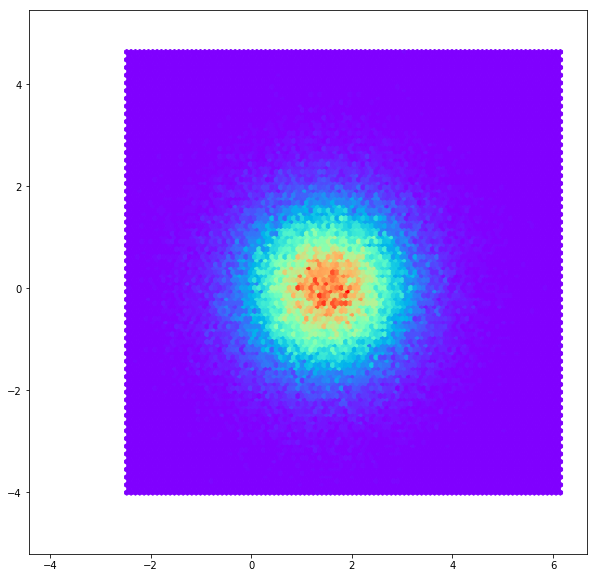

In [114]:
# Our different flow blocks
block_maf = [ MAFlow, ReverseFlow ]
# Create normalizing flow
flow_maf = NormalizingFlow(dim=2, blocks=block_maf, flow_length=8, density=distrib.MultivariateNormal(torch.zeros(2), torch.eye(2)))
# Create optimizer algorithm
optimizer = optim.Adam(flow_maf.parameters(), lr=1e-3)
# Add learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.99995)
# Launch optimization
train_flow(flow_maf, loss, optimizer, scheduler, density_wave_split, epochs=2000, plot_it=50)

## Inverse Autoregressive Flow

We have seen that in MAF, the sequential formulation of the transform introduced a slow optimization that we could enhance by using MADE networks. This still makes MAF quite slow for the sampling operation, as some the transformed dimensions depend on each other However, the astute reader will have noted that the inverse operation (equation (13)) did not have this problem. Indeed, here the output of the transform only depends on its input (even though still in an autoregressive manner). This makes MAF quite efficient for the training aspects.

Hence, we could consider that the transformed variable is defined as an inverse autoregressive mapping of the following form

$$
  f(\mathbf{z}_{i}) = \mathbf{z}_{i} g_\sigma(\mathbf{z}_{1:i}) + g_{\mu}(\mathbf{z}_{1:i}) \tag{14}
$$

   where $g_{\mu}$ and $g_{\sigma}$ depend only on the first $(i-1)$ elements of $\mathbf{z}$. The Jacobian is also still lower triangular, and the determinant is
   
$$
  \text{log }\left|\frac{\partial f(\mathbf{z})}{\partial \mathbf{z}}\right| = \sum_{i=k+1}^{D} \text{log }g_{\sigma}(\mathbf{z}_{1:i})
\tag{15} 
$$

Hence, this form can be thought of as the inverse function of the MAF autoregressive flow, which was proposed in the original Inverse Autoregressive Flow (IAF) paper [3](#references). (Note that the IAF paper actually predates the MAF paper). However, unlike MAF, this form directly allows parallel computation of the transform in a single forward pass. Even though sampling from an IAF is easy (since it is just a forward pass on the input), the density estimation is slower (which is the reason why MAF was proposed). Indeed, the inverse operation needs to evaluate the chain of inverse transformations $f^{-1}_k$, $k = K, \dots, 0$

$$
  \mathbf{z}_{k-1, 1} = \frac{\mathbf{z}_{k, 1} - \mu_{k, 1}}{\sigma_{k, 1}},\\
  \mathbf{z}_{k-1, i} = \frac{\mathbf{z}_{k, i} - \mu_{k, i} (\mathbf{z}_{k-1, 1:i-1})}{\sigma_{k, i} (\mathbf{z}_{k-1, 1:i-1})}. 
  \tag{16}
$$

This can be expensive, but as long as $g_{\mu}$ and $g_{\sigma}$ are implemented as autoregressive transformations, it is possible. Hence, we can still rely on the same MADE trick that we used in the implementation of MAF.

Therefore, the final implementation of this operation is done through the `IAFlow` class

In [28]:
# Masked Autoregressive Flow
class IAFlow(Flow):
    def __init__(self, dim, n_hidden=32, n_layers=2, activation=nn.ReLU):
        super(IAFlow, self).__init__()
        self.ar_net = self.transform_net(dim * 2, dim * 2, n_hidden, n_layers, activation)
        self.init_parameters()
        self.bijective = True
        self.sigma = []

    def transform_net(self, nin, nout, nhidden, nlayer, activation):
        net = nn.ModuleList()
        for l in range(nlayer):
            net.append(MaskedLinearAR(l==0 and nin or nhidden, l==nlayer-1 and nout or nhidden))
            net.append(activation())
        return nn.Sequential(*net)
        
    def _call(self, z):
        out = self.ar_net(z)
        m, s = out.chunk(2, dim=1)
        z, h = z.chunk(2, dim=1)
        self.sigma = torch.sigmoid(s)
        z = sigma * z + (1 - sigma) * m
        return torch.cat((z, h), dim=1)

    def _inverse(self, z):
        z = (z - self.g_mu(z)) / self.g_sig(z)
        return z

    def log_abs_det_jacobian(self, z):
        return torch.sum(torch.abs(self.g_sig(z)))

### Context-based IAF

In the original IAF paper [3], the authors propose a more numerically-stable version of this flow, which resemble the LSTM cells. In this case, they introduce a context vector $\mathbf{h}$ and rely on an autoregressive neural network to output two vectors $[\mathbf{m}_t,\mathbf{s}_t]$

$$
[ \mathbf{m}_t,\mathbf{s}_t ] \leftarrow \text{AutoregressiveNN}[t]
(\mathbf{z}_t,\mathbf{h};\mathbf{\sigma})
\tag{15}
$$

and we compute $ \mathbf{z}_t $ as


$$
\begin{align}
  \mathbf{\sigma}_t &= \text{sigmoid}(\mathbf{s}_t)\\
  \mathbf{z}_t &= \mathbf{\sigma}_t \odot \mathbf{z}_{t-1} + (1 - \mathbf{\sigma}_t) \odot \mathbf{m}_{t}
\end{align}
\tag{16}
$$

This new formulation is implemented in the following `ContextIAFlow` (based on our previous implementation of the autoregressive NN as `MaskedLinearAR`)

In [29]:
# Masked Autoregressive Flow
class ContextIAFlow(Flow):
    def __init__(self, dim, n_hidden=32, n_layers=2, activation=nn.ReLU):
        super(ContextIAFlow, self).__init__()
        self.ar_net = self.transform_net(dim * 2, dim * 2, n_hidden, n_layers, activation)
        self.init_parameters()
        self.bijective = True
        self.sigma = []

    def transform_net(self, nin, nout, nhidden, nlayer, activation):
        net = nn.ModuleList()
        for l in range(nlayer):
            net.append(MaskedLinearAR(l==0 and nin or nhidden, l==nlayer-1 and nout or nhidden))
            net.append(activation())
        return nn.Sequential(*net)
        
    def _call(self, z):
        out = self.ar_net(z)
        m, s = out.chunk(2, dim=1)
        z, h = z.chunk(2, dim=1)
        self.sigma = torch.sigmoid(s)
        z = sigma * z + (1 - sigma) * m
        return torch.cat((z, h), dim=1)

    def _inverse(self, z):
        z = (z - self.g_mu(z)) / self.g_sig(z)
        return z

    def log_abs_det_jacobian(self, z):
        return torch.sum(torch.abs(self.g_sig(z)))

### Testing IAF 

In [31]:
# Our different flow blocks
block_iaf = [ IAFlow, ShuffleFlow ]
# Create normalizing flow
flow_iaf = NormalizingFlow(dim=2, blocks=block_iaf, flow_length=8, density=distrib.MultivariateNormal(torch.zeros(2), torch.eye(2)))
# Create optimizer algorithm
optimizer = optim.Adam(flow_iaf.parameters(), lr=1e-3)
# Add learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.99995)
# Launch the optimization
train_flow(flow_iaf, loss, optimizer, scheduler, density_wave_split, epochs=100, plot_it=1)

AttributeError: 'IAFlow' object has no attribute 'g_sig'

<Figure size 720x720 with 0 Axes>

# Comparing complex flows

In [ ]:
# Main class for normalizing flow
class NormalizingFlow(nn.Module):

    def __init__(self, dim, blocks, flow_length, density):
        super().__init__()
        biject = []
        for f in range(flow_length):
            for b_flow in blocks:
                biject.append(b_flow(dim))
        self.transforms = transform.ComposeTransform(biject)
        self.bijectors = nn.ModuleList(biject)
        self.base_density = density
        self.final_density = distrib.TransformedDistribution(density, self.transforms)
        self.log_det = []

    def forward(self, z):
        self.log_det = []
        # Applies series of flows
        for b in range(len(self.bijectors)):
            self.log_det.append(self.bijectors[b].log_abs_det_jacobian(z))
            z = self.bijectors[b](z)
        return z, self.log_det

# Our different flow blocks
block_real_nvp = [ AffineCouplingFlow, ReverseFlow ]
block_maf = [ MAFlow, ShuffleFlow ]
block_iaf = [ IAFlow, ShuffleFlow ]
# Create normalizing flow
flow = NormalizingFlow(dim=2, blocks=block_mlp, flow_length=8, density=distrib.MultivariateNormal(torch.zeros(2), torch.eye(2)))

$$
0.5[ \sum_i \log \sigma_2^(i) - \sum_i \log \sigma_1^(i) + \sum_i \frac{\sigma_2^(i)}{\sigma_1^(i)} + \sum_i \frac{(\mu_2^(i) = \mu_1^(i))^2)} { \sigma_2^(i)} ]
$$



In [ ]:
def density_ring(z):
    z1, z2 = torch.chunk(z, chunks=2, dim=1)
    norm = torch.sqrt(z1 ** 2 + z2 ** 2)
    exp1 = torch.exp(-0.5 * ((z1 - 2) / 0.8) ** 2)
    exp2 = torch.exp(-0.5 * ((z1 + 2) / 0.8) ** 2)
    u = 0.5 * ((norm - 4) / 0.4) ** 2 - torch.log(exp1 + exp2)
    return torch.exp(-u)

# Plot it
x = np.linspace(-5, 5, 1000)
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])
plt.hexbin(z[:,0], z[:,1], C=density_ring(torch.Tensor(z)).numpy().squeeze(), cmap='rainbow')
plt.title('Target density', fontsize=18);

In [ ]:
def loss(density, zk, log_jacobians):
    sum_of_log_jacobians = sum(log_jacobians)
    return (-sum_of_log_jacobians - torch.log(density(zk) + 1e-9)).mean()

### References

<a id="reference1"></a>
[1] Rezende, Danilo Jimenez, and Shakir Mohamed. "Variational inference with normalizing flows." _arXiv preprint arXiv:1505.05770_ (2015). [link](http://arxiv.org/pdf/1505.05770)

[2] Dinh, L., Sohl-Dickstein, J., & Bengio, S. Density estimation using Real NVP. arXiv preprint arXiv:1605.08803. (2016). [link](https://arxiv.org/abs/1605.08803)

[3] Kingma, Diederik P., Tim Salimans, and Max Welling. "Improving Variational Inference with Inverse Autoregressive Flow." _arXiv preprint arXiv:1606.04934_ (2016). [link](https://arxiv.org/abs/1606.04934)

[4] Papamakarios, G., Pavlakou, T., & Murray, I. (2017). Masked autoregressive flow for density estimation. In Advances in Neural Information Processing Systems (pp. 2338-2347). [link](http://homepages.inf.ed.ac.uk/imurray2/pub/17maf/maf.pdf)

[5] Germain, Mathieu, et al. "Made: masked autoencoder for distribution estimation." International Conference on Machine Learning. 2015. [link](http://www.jmlr.org/proceedings/papers/v37/germain15.pdf)

### Inspirations and resources

https://blog.evjang.com/2018/01/nf1.html  
https://github.com/ex4sperans/variational-inference-with-normalizing-flows  
https://akosiorek.github.io/ml/2018/04/03/norm_flows.html  
https://github.com/abdulfatir/normalizing-flows  

